In [120]:
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt
import random
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D,
    Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam

In [121]:
DATASET_PATH = "/kaggle/input/brain-tumor-mri-scans"
IMG_SIZE = (128, 128)
images = []
labels = []

def load_and_clean_dataset(path):
    for label in os.listdir(path):
        class_path = os.path.join(path, label)

        if not os.path.isdir(class_path):
            continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            try:
                img = cv2.imread(img_path)

                # clean dataset 
                if img is None:
                    continue

                images.append(img)
                labels.append(label)

            except:
                print("Corrupted image:", img_path)

load_and_clean_dataset(DATASET_PATH)

print("Total images:", len(images))


Total images: 7023


Processed images shape: (7023, 128, 128)


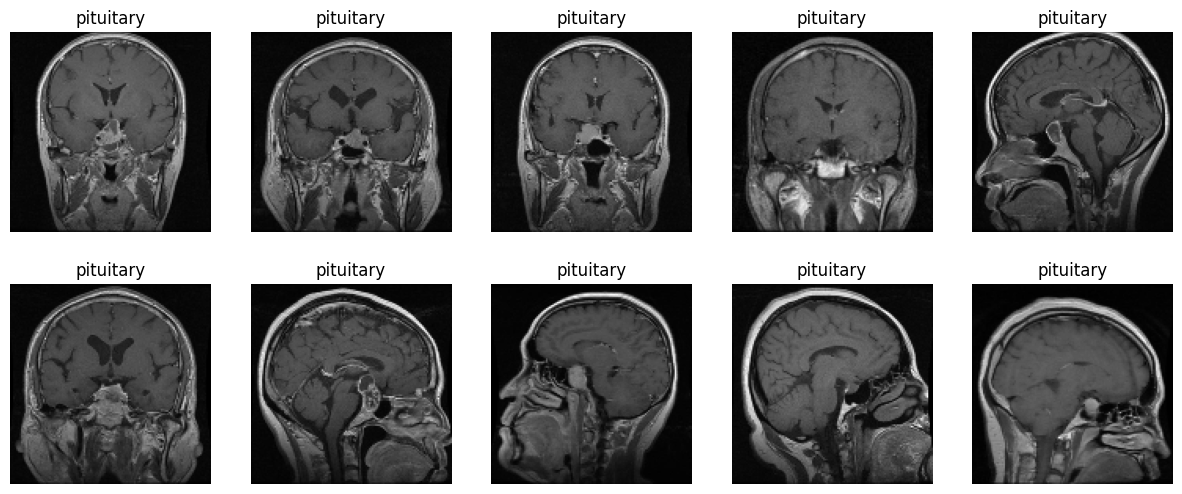

In [122]:
processed_images = []

for img in images:
    # Resize
    img = cv2.resize(img, IMG_SIZE)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Normalize
    gray = gray / 255.0

    processed_images.append(gray)

processed_images = np.array(processed_images)

print("Processed images shape:", processed_images.shape)
# Visualize some samples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax = axes.flat[i]
    ax.imshow(processed_images[i], cmap='gray')
    ax.set_title(labels[i])
    ax.axis('off')
plt.show()

 Gaussian Blur was applied to reduce noise while preserving important structures

In [123]:
gaussian_images = []

for img in processed_images:
    blur = cv2.GaussianBlur(img, (3,3), 0)
    gaussian_images.append(blur)

gaussian_images = np.array(gaussian_images)


 Histogram Equalization enhanced contrast and improved tumor visibility

In [124]:
equalized_images = []

for img in gaussian_images:
    img_uint8 = (img * 255).astype(np.uint8)
    eq = cv2.equalizeHist(img_uint8)
    eq = eq / 255.0
    equalized_images.append(eq)

equalized_images = np.array(equalized_images)


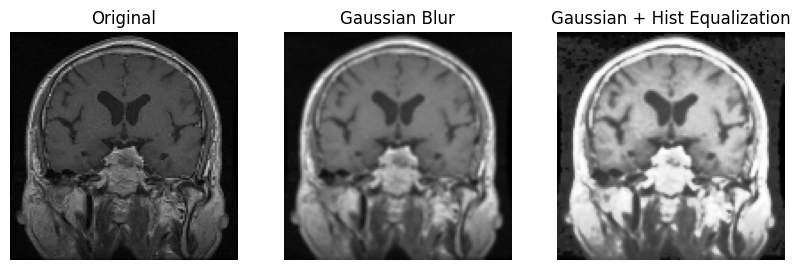

In [125]:
index = 5

plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(processed_images[index], cmap='gray')
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Gaussian Blur")
plt.imshow(gaussian_images[index], cmap='gray')
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Gaussian + Hist Equalization")
plt.imshow(equalized_images[index], cmap='gray')
plt.axis("off")

plt.show()

Median filter was tested but showed limited improvement for MRI images

In [126]:
median_images = []

for img in processed_images:
    img_uint8 = (img * 255).astype(np.uint8)
    median = cv2.medianBlur(img_uint8, 5)
    median = median / 255.0
    median_images.append(median)

median_images = np.array(median_images)


 CLAHE improved local contrast and tumor visibility

In [127]:
clahe_images = []
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

for img in processed_images:
    img_uint8 = (img * 255).astype(np.uint8)
    cl = clahe.apply(img_uint8)
    cl = cl / 255.0
    clahe_images.append(cl)

clahe_images = np.array(clahe_images)


Sharpening amplified noise and produced artificial edges

In [128]:
kernel = np.array([[0,-1,0],
                   [-1,5,-1],
                   [0,-1,0]])

sharpen_images = []

for img in processed_images:
    img_uint8 = (img * 255).astype(np.uint8)
    sharp = cv2.filter2D(img_uint8, -1, kernel)
    sharp = sharp / 255.0
    sharpen_images.append(sharp)

sharpen_images = np.array(sharpen_images)


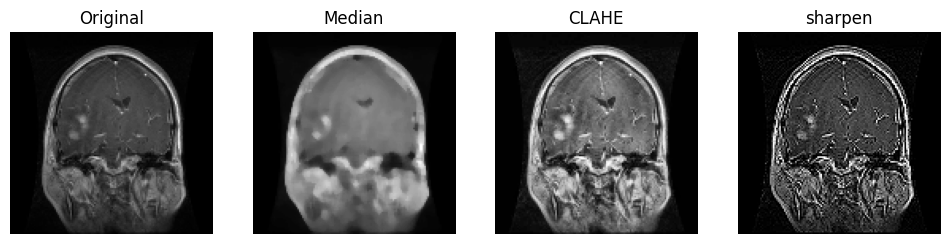

In [129]:
i = 6000

titles = ["Original", "Median", "CLAHE", "sharpen"]
imgs = [
    processed_images[i],
    median_images[i],
    clahe_images[i],
    sharpen_images[i]
]

plt.figure(figsize=(12,4))

for idx in range(4):
    plt.subplot(1,4,idx+1)
    plt.title(titles[idx])
    plt.imshow(imgs[idx], cmap='gray')
    plt.axis("off")

plt.show()


CLAHE was selected for its ability to enhance local contrast, while mild sharpening was applied to improve tumor boundary clarity.
This combination provided the most visually informative results.


In [130]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

print("Class Label Mapping:")
for idx, class_name in enumerate(encoder.classes_):
    print(f"{class_name} --> {idx}")


Class Label Mapping:
glioma --> 0
healthy --> 1
meningioma --> 2
pituitary --> 3


In [131]:
import numpy as np

unique_labels = np.unique(encoded_labels)
print("Encoded labels found in dataset:", unique_labels)


Encoded labels found in dataset: [0 1 2 3]


In [132]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    clahe_images,
    encoded_labels,
    test_size=0.2,
    random_state=42,
    stratify=encoded_labels
)

print(X_train.shape, X_test.shape)


(5618, 128, 128) (1405, 128, 128)


In [133]:
X_train = X_train[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

print(X_train.shape)  
print(X_test.shape)   

(5618, 128, 128, 1)
(1405, 128, 128, 1)


In [134]:
unique, counts = np.unique(y_train, return_counts=True)
print("Number of images per class in train dataset")
for cls, count in zip(encoder.classes_, counts):
    print(f"{cls}: {count}")

Number of images per class in train dataset
glioma: 1297
healthy: 1600
meningioma: 1316
pituitary: 1405


The data is imbalanced. We perform augmentation to balance classes in train dataset.

In [135]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=20,          
    width_shift_range=0.1,      
    height_shift_range=0.1,     
    shear_range=0.1,            
    zoom_range=0.1             
)

test_datagen = ImageDataGenerator()

In [136]:
train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size=32
)

test_generator = test_datagen.flow(
    X_test,
    y_test,
    batch_size=32,
    shuffle=False
)

In [137]:
from collections import Counter

def augment_class_balance(X, y, datagen, batch_size=1):
    class_counts = Counter(y)
    max_count = max(class_counts.values())

    Xa, ya = [], []

    for cls in class_counts:
        idxs = np.where(y == cls)[0]
        X_cls = X[idxs]
        y_cls = y[idxs]

        # Add original images
        Xa.extend(X_cls)
        ya.extend(y_cls)

        n_to_augment = max_count - len(X_cls)

        if n_to_augment > 0:
            gen = datagen.flow(X_cls, y_cls, batch_size=batch_size, shuffle=True)
            for _ in range(n_to_augment):
                augmented_image, _ = next(gen)
                Xa.append(augmented_image[0])
                ya.append(cls)

    return np.array(Xa), np.array(ya)

In [138]:
X_train_balanced, y_train_balanced = augment_class_balance(X_train, y_train, train_datagen, batch_size=1)

In [139]:
unique, counts = np.unique(y_train_balanced, return_counts=True)
print("Number of images per class after augmentation:")
for cls, count in zip(encoder.classes_, counts):
    print(f"{cls}: {count}")

Number of images per class after augmentation:
glioma: 1600
healthy: 1600
meningioma: 1600
pituitary: 1600


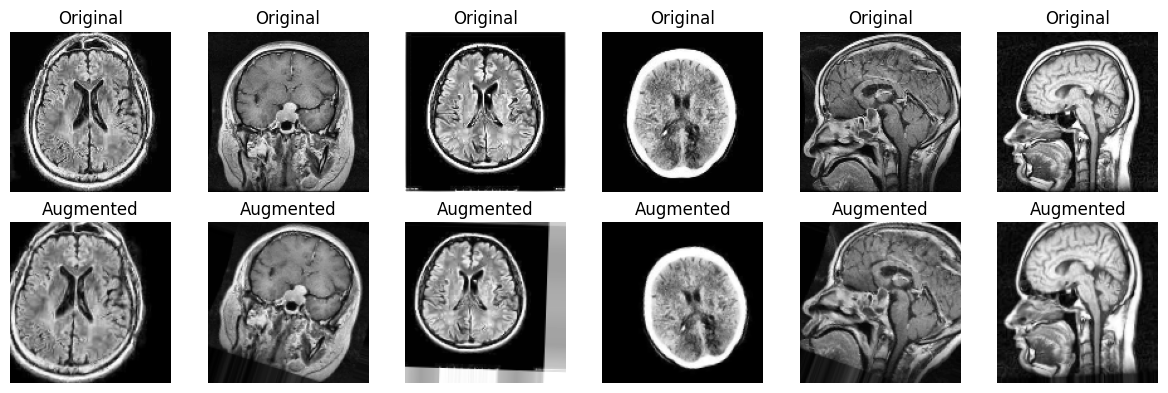

In [140]:
import matplotlib.pyplot as plt
import numpy as np

n_pairs = 6  

plt.figure(figsize=(12, 4))

for i in range(n_pairs):
    orig_img = X_train[i]

    
    img_batch = np.expand_dims(orig_img, 0)
    aug_iter = train_datagen.flow(img_batch, batch_size=1)
    aug_img = next(aug_iter)[0]  
    # original image
    plt.subplot(2, n_pairs, i+1)
    plt.imshow(orig_img, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # agumented image
    plt.subplot(2, n_pairs, i+1+n_pairs)
    plt.imshow(aug_img, cmap='gray')
    plt.title("Augmented")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [141]:
print(X_train_balanced.shape)

(6400, 128, 128, 1)


In [142]:
from tensorflow.keras.utils import to_categorical
y_train_balanced = to_categorical(y_train_balanced, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [143]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

# Convolution Block 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution Block 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution Block 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(4, activation='softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [144]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [145]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

In [146]:
history = model.fit(
    X_train_balanced, y_train_balanced,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5047 - loss: 1.0770 - val_accuracy: 0.8071 - val_loss: 0.5492
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7666 - loss: 0.5795 - val_accuracy: 0.8342 - val_loss: 0.4545
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7995 - loss: 0.4986 - val_accuracy: 0.8698 - val_loss: 0.3795
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8389 - loss: 0.4088 - val_accuracy: 0.8747 - val_loss: 0.3657
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8516 - loss: 0.3779 - val_accuracy: 0.8769 - val_loss: 0.3145
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8899 - loss: 0.3021 - val_accuracy: 0.9068 - val_loss: 0.3009
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9013 - loss: 0.2617 - val_accuracy: 0.9089 - val_loss: 0.2741
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9189 - loss: 0.2217 - val_accu

In [147]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9475 - loss: 0.2613
Test Accuracy: 0.9416370391845703


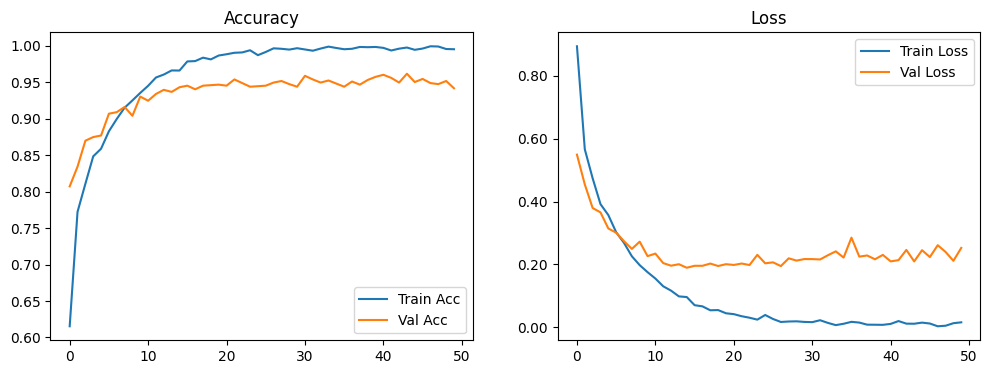

In [148]:
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.show()

In [149]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = y_test
y_true = np.argmax(y_test, axis=1)
# Metrics
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Accuracy  : 0.9416
Precision : 0.9443
Recall    : 0.9416
F1-score  : 0.9423


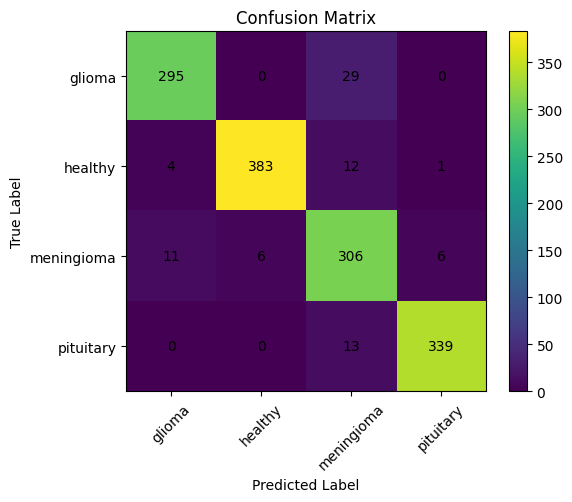

              precision    recall  f1-score   support

      glioma       0.95      0.91      0.93       324
     healthy       0.98      0.96      0.97       400
  meningioma       0.85      0.93      0.89       329
   pituitary       0.98      0.96      0.97       352

    accuracy                           0.94      1405
   macro avg       0.94      0.94      0.94      1405
weighted avg       0.94      0.94      0.94      1405



In [150]:
# confusion
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
class_names = encoder.classes_

plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()

plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
# for every type , recall precision f1
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=encoder.classes_
))